### Load, split and save train and test dataframes


In [38]:
import pandas as pd
import urllib.parse
import os
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from help_functions import get_y_true

In [39]:
MINIMAL_NR_IMAGES = 100

Load naive labels, and pre-process urls.

In [6]:
skip = True
if not skip:
    NAIVE_LABELS_PATH = 'data/commonswiki-20220220-files-naive-labels.json.bz2'
    naive_labels = pd.read_json(NAIVE_LABELS_PATH)

    # # With this encoded url, only 190k images aren't found, while with "url" 790k aren't found
    # naive_labels['url'] = naive_labels['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
    # naive_labels['can_be_opened'] = naive_labels['url'].apply(lambda url : os.path.isfile('/scratch/WIT_Dataset/images/' + url))
    # print(f'Total number of files: {naive_labels.shape[0]}.')

    # naive_labels = naive_labels.loc[naive_labels.can_be_opened == True].reset_index(drop=True)

    # naive_labels.rename(columns={'new_labels': 'labels'}, inplace=True)
    # print(f'Total number of files that can be opened: {naive_labels.shape[0]}.')

ORES labels.

In [32]:
ORES_LABELS_PATH = '/dlabdata1/piccardi/WikipediaImageClassification/training_set.pkl'
ores_labels = pd.read_pickle(ORES_LABELS_PATH).sample(1_100_000, random_state=0)
ores_labels['url'] = ores_labels.image_path.apply(lambda r: r[1:])
ores_labels = ores_labels.rename(columns={'page_title': 'title'}).drop(columns=['image_path'])

# With this encoded url, only 190k images aren't found, while with "url" 790k aren't found
ores_labels['url'] = ores_labels['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
ores_labels['can_be_opened'] = ores_labels['url'].apply(lambda url : os.path.isfile('/scratch/WIT_Dataset/images/' + url))
print(f'Total number of files: {ores_labels.shape[0]}.')
ores_labels = ores_labels.loc[ores_labels.can_be_opened == True].reset_index(drop=True)

# ores_labels.rename(columns={'new_labels': 'labels'}, inplace=True)
print(f'Total number of files that can be opened: {ores_labels.shape[0]}.')
ores_labels.head()

Total number of files: 1100000.
Total number of files that can be opened: 1100000.


,title,labels,url,can_be_opened
0,James Tissot,"[Geography.Regions.Europe.Europe*, Geography.R...",5/54/The_Return_of_the_Prodigal_Son_James_Tiss...,True
1,Ceres (dwarf planet),"[STEM.Space, STEM.STEM*]",a/a2/PIA20862-Ceres-DwarfPlanet-Dawn-4thMapOrb...,True
2,Great Grimsby Street Tramways,"[Geography.Regions.Europe.Europe*, Geography.R...",f/fa/Grimsby_-_The_Old_Tram_Depot_-_geograph.o...,True
3,"Gisborne, New Zealand","[Geography.Regions.Oceania, Geography.Geograph...",9/93/Gisborne_nz_2.jpg,True
4,Hugh Evan-Thomas,"[Geography.Regions.Europe.Europe*, History and...",1/1d/Rear_Admiral_H._Evan-Thomas.jpg,True


#### Extra cleaning 

When running `model.evaluate()`, it fails with the `PIL.UnidentifiedImageError` exception error. It's mostly images from format .webp, but there are also some .png images. Remove them from the dataset. (Example: `!ls /scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png` 

`PIL.Image.open('/scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png')`
)

In [ ]:
import PIL
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
if not skip:
    for index, row in tqdm(naive_labels.iterrows(), total=naive_labels.shape[0]):
        try:
            img = Image.open('/scratch/WIT_Dataset/images/' + row.url)
        except PIL.UnidentifiedImageError:
            print(row.url)
            naive_labels.at[index, 'can_be_opened'] = False
        except Exception as e:
            print(e)
            naive_labels.at[index, 'can_be_opened'] = False

In [ ]:
# Only keep the files that can be opened
if not skip:
    naive_labels = naive_labels.loc[naive_labels.can_be_opened == True].reset_index(drop=True)
    naive_labels.to_json('data/commonswiki-20220531-files-naive-labels.json.bz2', compression='bz2')
    print(f'Total number of files that can be opened: {naive_labels.shape[0]}.')

    print(naive_labels.shape)
    naive_labels.head(2)

Total number of files that can be opened: 1817901.
(1817901, 6)


,id,title,url,categories,labels,can_be_opened
0,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...","1/13/""Carnevale_di_Torino""._Felice_Cerruti_-_f...","[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Places, Society]",True
1,14890941,"""Escena de playa con figura"".jpg","c/c2/""Escena_de_playa_con_figura"".jpg","[Pedro Lira, People with dogs in art]","[Culture, Entertainment]",True


#### Load dataset that has been cleaned from "UnidentifiedImage error" and only keep .jpg files

In [40]:
naive_labels = pd.read_json('data/commonswiki-20220601-files-naive-labels.json.bz2', compression='bz2')
print(f"{naive_labels.loc[naive_labels.url.str.contains('.jpeg', case=False)].shape[0]} images of type .jpeg")
naive_labels_jpg = naive_labels.loc[naive_labels.url.str.contains('.jpg', case=False)]
print(f'{naive_labels_jpg.shape[0]} images of type .jpg')

Do the same thing for ORES labels.

In [33]:
ores_labels_jpg = ores_labels.loc[ores_labels.url.str.contains('.jpg', case=False)]
ores_labels_jpg.shape


(1088023, 4)

Remove labels with less than a certain number of images

Found 1088023 non-validated image filenames belonging to 64 classes.
Removed 0 images that were only labeled as the removed labels. Left with 1.09 M images.


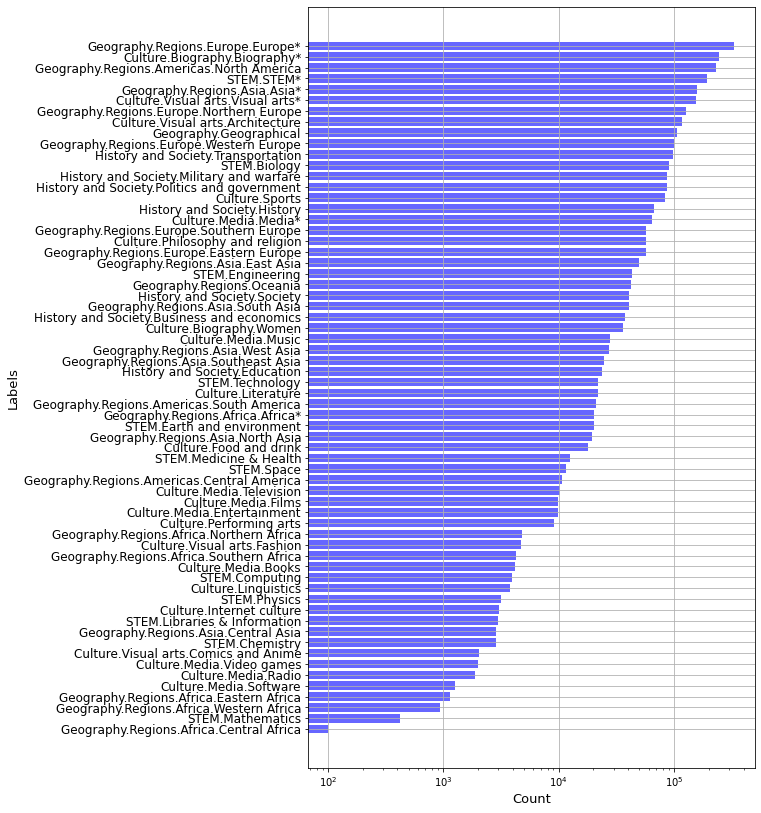

In [35]:
df_name = 'naive'
if df_name == 'naive':
    dataframe = naive_labels_jpg.copy()
elif df_name == 'ores':
    dataframe = ores_labels_jpg.copy()


_generator = ImageDataGenerator() 
_data = _generator.flow_from_dataframe(dataframe=dataframe, 
                                       directory='/scratch/WIT_Dataset/images', 
                                       x_col='url', 
                                       y_col='labels', 
                                       class_mode='categorical', 
                                       validate_filenames=False)

y_true = get_y_true(_data.samples, _data.class_indices, _data.classes)

sorted_indices = np.argsort(np.sum(y_true, axis=0))
sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]

mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

_ = plt.figure(figsize=(8, 14))
# _ = plt.title('Number of times a label is assigned to an image', fontdict={'fontsize': 14})

_ = plt.barh(np.array(range(y_true.shape[1]))[mask_kept], sorted_images_per_class[mask_kept], color='blue', alpha=0.6)
_ = plt.barh(np.array(range(y_true.shape[1]))[mask_removed], sorted_images_per_class[mask_removed], color='red', alpha=0.6)

_ = plt.yticks(range(y_true.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices], fontsize=12)
_ = plt.xscale('log')
_ = plt.xlabel('Count', fontsize=13)
_ = plt.ylabel('Labels', fontsize=13)
_ = plt.grid(True)

# plt.legend(['Kept', 'Removed'], loc='upper right', fontsize=12)

indices_of_classes_to_remove = np.where(np.sum(y_true, axis=0) < MINIMAL_NR_IMAGES)
classes_to_remove = np.array(list(_data.class_indices.keys()))[indices_of_classes_to_remove]

dataframe['labels'] = dataframe['labels'].apply(lambda labels: [el for el in labels if el not in classes_to_remove])
naive_labels_clean = dataframe[dataframe['labels'].str.len() != 0]
print(f'Removed {dataframe.shape[0] - naive_labels_clean.shape[0]} images that were only labeled as the removed labels. Left with {naive_labels_clean.shape[0]/1e6:.2f} M images.')

Split dataset and save so the same training, validation and test sets are used throughout. Sample 500k images first

In [36]:
# Sample 600k images
samples = dataframe.sample(n=600_000, random_state=7)

In [37]:
train_df, test_df = train_test_split(samples, test_size=0.05, random_state=7)

print(f'Train set: {train_df.shape[0]} images ({train_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Test set:  {test_df.shape[0]}  images ({test_df.shape[0] / samples.shape[0]:.2f}%)')

os.mkdir('data/split_dataframes_600k_64_oreslabels_20220609')

train_df.to_json('data/split_dataframes_600k_64_oreslabels_20220609/train_df.json.bz2', compression='bz2')
test_df.to_json('data/split_dataframes_600k_64_oreslabels_20220609/test_df.json.bz2', compression='bz2')

Train set: 570000 images (0.95%)
Test set:  30000  images (0.05%)
